<a href="https://colab.research.google.com/github/hs0224/a-professor-student-research-club/blob/main/private/Mr_Mink/Chap04Deeper0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4장 숫자 분류기의 학습 내부 들여다보기
##### * 3장은 윤리관련 내용...
## 4.1 픽셀: 커퓨터 영상 처리의 기본 토대

In [1]:
# MNIST 샘플 데이터 셋 다운로드
from fastai.vision.all import *

path = untar_data(URLs.MNIST_SAMPLE)

##### * MNIST는 손으로 쓴 숫자 이미지들

In [2]:
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/7'),Path('/root/.fastai/data/mnist_sample/train/3')]

### (path/'train').ls()
##### * ls(): 해당 디렉토리의 내용을 확인할 수 있다.
##### - fastai에서 제공하는 L 클래스 객체를 반환한다.(L클래스는 list를 기능확장한 것)
##### - '목록(list)'과 '목록의 개수(len)'를 함께 출력한다.
##### * '3'과 '7'의 폴더를 확인할 수 있고, 이는 '데이터셋'으로 "레이블(label 또는 target)"이라고 한다.

### 3과 7을 분리해서 출력하고 확인해 보도록하자.

In [3]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [4]:
# 데이터셋중 하나 출력
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

### PIL(Python Imaging Library)가 제공하는 Image 클래스를 사용 중.
##### * PIL은 이미지 open, manipulate, print 할 때, 가장 널리 사용하는 패키지.
##### ** 주피터 노트북은 "PIL 라이브러리가 표현하는 이미지를 '즉시' 인식"할 수 있다.
##### *** 컴퓨터는 모든 것을 숫자로 표현한다. 따라서, 이미지를 구성하는 숫자를 확인하려면 '넘파이 배열' 혹은 '파이토치 텐서'로 나타내야 한다.

In [5]:
# 넘파이 array 변환
array(im3)[4:10, 4:10] #슬라이싱

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [6]:
# 파이토치 tensor로 표현
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

##### * array는 Numpy, tensor는 Pytorch로 비슷한 형태지만, 다르다는 것을 알 수 있다.
### 판다스 데이터프레임으로 숫자의 값에 따라 색상을 그라데이션 형태로 표현해보기
##### * 숫자 -> 그림

In [7]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


### df = pd.DataFrame(im3_t[4:15, 4:22])
##### * pd는 pandas 를 의미.
##### ** DataFrame()으로 데이터프레임 생성.
##### *** im3_t[4:15, 4:22] 에서 4:15 은 4 ~ 14, 그리고 4:22 은 4 ~ 21 을 의미한다. 따라서, 데이터 프레임의 행은 0부터 (14 - 4 = )10, 열은 0부터 (21 - 4 = )17 까지의 범위를 표현하게 된다.
### df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')
##### * df.style: df의 스타일 클래스
##### ** .set_properties(): 속성 설정 함수
##### *** (**{'font-size':'6pt'}): **의 의미는 잘 모르겠지만, 폰트사이즈를 6포인트로 설정하겠다는 의미.
##### **** .background_gradient('Greys') 배경의 그라데이션을 'Greys(흑백)'으로 설정.
##### ***** 디자인적인 의미에서 그라데이션을 기울기로 나타낸다. 색이 진해질 수록 기울기가 높다.
### 숫자 -> 그림 분석
##### * 완전 흰색은 0!, 완전 검은색은 255!
##### ** 이미지는 28 x 28 이다.
##### *** 즉, 가로 28개, 세로 28개의 픽셀들(784개)로 구성된다는 뜻이다.

## 4.2 첫번째 시도: 픽셀 유사성
#### 시도 1: 숫자 3과 7에 대한 모든 이미지의 평균 픽셀값 구하기
##### 두 숫자에 대해 얻은 '평균 픽셀값'은 "이상적인" 3과 7로 정의해볼 수 있다.
### ① 평균 픽셀값 구하기:

In [8]:
# 모든 숫자 3 이미지를 쌓아 올린 텐서를 만들어 보기.
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

### seven_tensors = [tensor(Image.open(o)) for o in sevens]
##### * list[] 안에 for문: 리스트 컴프리헨션
##### ** 통상적인 반복문 사용과 비교해 코드의 양도 더 적고, 속도도 월등히 빠름.

### 리스트 제대로 만들어졌는지 확인하기
##### * 위에서 tensor(Image.open(o)) 코드를 통해 tensor 형식으로 이미지가 생성되었으므로, 출력하려면 fastai가 제공하는 show_image 함수를 사용 해야한다.

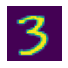

In [9]:
show_image(three_tensors[1]);

##### ! 우리의 목표는 "각 픽셀 위치의 전체 평균을 계산 -> 각 픽셀의 강도 구하기".
##### /_> 리스트 내의 모든 이미지를 "3차원 텐서 '하나로' 결합" 해야 한다.
##### * 일반적으로 3차원 텐서는 '랭크3 텐서' 라고 한다.
##### ** stack(): 컬렉션에 담긴 개별 텐서들을 쌓아올려 단일 텐서로 만드는 역할 (파이토치 제공)
##### *** (파이토치 제공) '일부' 연산은 '부동 소수형 데이터만' 을 지원. => 작업에 따라 '형변환'을 해야 한다.

In [10]:
# 픽셀값을 부동소수로 표현할 때는 값을 0 ~ 1 로 맞춰줘야 한다.
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

### stacked_threes.shape
##### * tensor.shape: "각 축의 길이를 표현" 하는 텐서의 '속성'
##### ** 텐서를 구성하는 '각 축의 의미'는 순전히 텐서를 만드는 '우리가 정한다'.
##### *** 랭크: 텐서의 차원 또는 축의 개수, shape: 각 축의 크기를 표현. 따라서, '랭크 = 텐서' 로 여길 수 있다.